In [1]:
import sys
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model
from livelossplot.keras import PlotLossesCallback
from keras.losses import mse
from keras import backend as K

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


Using TensorFlow backend.


In [2]:
X_ccsm4 = xr.open_dataset('data/rcp26/CCSM4/rcp26_CCSM4_grid.nc')
X_ccsm4_arr = X_ccsm4.to_array().values
X_cesm = xr.open_dataset('data/rcp26/CESM1-CAM5/rcp26_CESM1-CAM5_grid.nc')
X_cesm_arr = X_cesm.to_array().values
X_canesm = xr.open_dataset('data/rcp26/CanESM2/rcp26_CanESM2_grid.nc')
X_canesm_arr = X_canesm.to_array().values
X_cnrm = xr.open_dataset('data/rcp26/CNRM-CM5/rcp26_CNRM-CM5_grid.nc')
X_cnrm_arr = X_cnrm.to_array().values
X_miroc = xr.open_dataset('data/rcp26/MIROC5/rcp26_MIROC5_grid.nc')
X_miroc_arr = X_miroc.to_array().values
X_mpi = xr.open_dataset('data/rcp26/MPI-ESM-LR/rcp26_MPI-ESM-LR_grid.nc')
X_mpi_arr = X_mpi.to_array().values
X_all_arr = np.array([X_ccsm4_arr, X_cesm_arr, X_canesm_arr, X_cnrm_arr, X_miroc_arr, X_mpi_arr])
X_all_arr = np.transpose(X_all_arr, axes=[0,2,3,4,1])
print(X_all_arr.shape)

(6, 2880, 72, 144, 1)


In [3]:
N_models, N_time, N_lat, N_lon, N_chan = X_all_arr.shape
BATCH_SIZE = N_models*144

In [4]:
X_all = np.hstack(X_all_arr).reshape((N_models*N_time, N_lat, N_lon, N_chan))
print(X_all.shape)

(17280, 72, 144, 1)


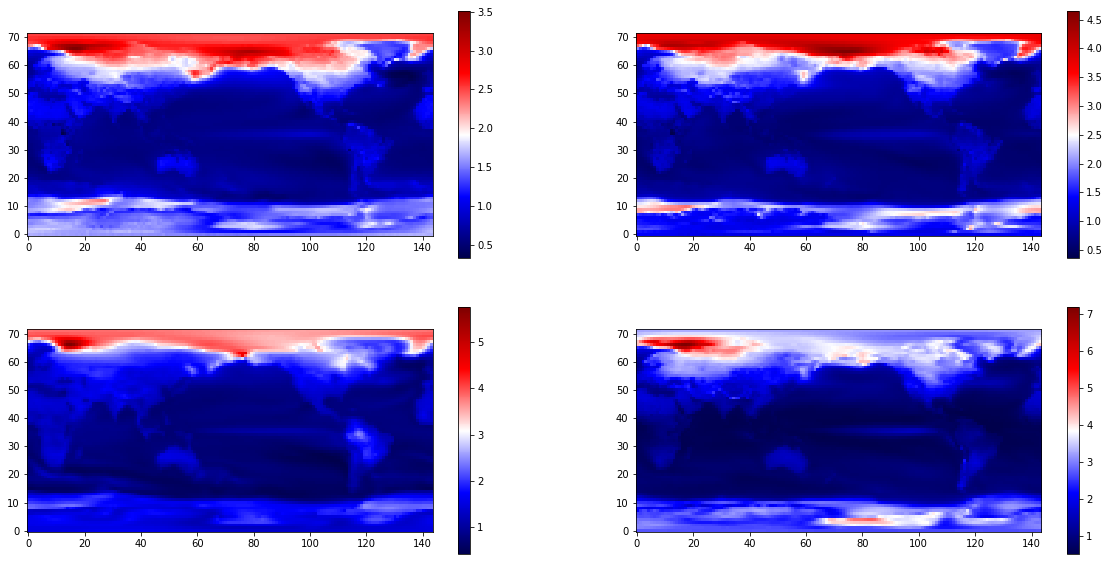

In [5]:
plt.figure(figsize=(20,10))
stdev = X_ccsm4.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,1)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_cesm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,2)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_canesm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,3)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_cnrm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,4)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [6]:
def plot_var_spatial(X, model, target_shape=(1, N_lat, N_lon, 1), name="model", t=0, c=0):
    X_t = X[c,t,:,:]
    X_pred = model.predict(X_t.reshape(target_shape)).reshape((N_lat, N_lon))
    plt.figure(figsize=(12,10))
    plt.subplot(1,2,1)
    plt.imshow(X_t, origin='lower')
    plt.title("{}, t={}".format(name, t))
    plt.subplot(1,2,2)
    plt.imshow(X_pred, origin='lower')
    plt.title("{}, t={}, decoded".format(name, t))
    plt.show()
    
def plot_err_spatial(X, model, target_shape=(1, N_lat, N_lon, 1), name="", t=0):
    plt.figure(figsize=(7,6))
    X_t = np.transpose(X, axes=[1,2,3,0])[t,:,:,:]
    X_pred = model.predict(X_t.reshape(target_shape)).reshape((N_lat, N_lon))
    print(X_pred.shape)
    X_err = np.abs(X_t.reshape((N_lat, N_lon)) - X_pred)
    plt.imshow(X_err.reshape((N_lat, N_lon)), origin='lower')
    plt.colorbar()
    plt.show()
    
def plot_var_time(X, model, name="", target_shape=(1, N_lat, N_lon, 1), x=0, y=0, c=0):
    X_orig = np.transpose(X, axes=[1,2,3,0])
    X_pred = model.predict_on_batch(X_orig.reshape(target_shape)).reshape((N_time, N_lat, N_lon, 1))
    print(X_pred.shape)
    plt.plot(range(X_orig.shape[0]), X_orig[:,x,y,c], c='blue')
    plt.plot(range(X_orig.shape[0]), X_pred[:,x,y,c], ':', c='red')
    plt.show()

### Dense Autoencoder

In [20]:
X_flat = X_all.reshape((X_all.shape[0], np.product(X_all.shape[1:])))
print(X_flat.shape)

input_0 = Input(batch_shape=(None, X_flat.shape[1]))
dense_1 = Dense(324, activation='relu', kernel_regularizer=l1(1.0e-5))(input_0)
dense_3 = Dense(X_flat.shape[1], activation='linear')(dense_1)

model = Model(inputs=input_0, outputs=dense_3)
model.compile(optimizer='adam', loss='mse')
model.summary()

(17280, 10368)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 10368)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 324)               3359556   
_________________________________________________________________
dense_18 (Dense)             (None, 10368)             3369600   
Total params: 6,729,156
Trainable params: 6,729,156
Non-trainable params: 0
_________________________________________________________________


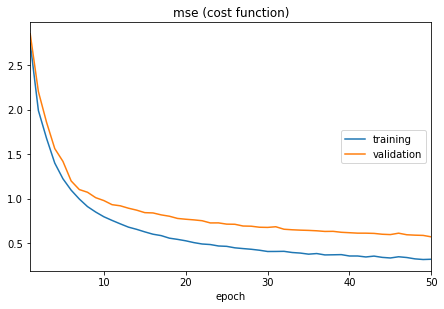

mse (cost function):
training   (min:    0.317, max:    2.746, cur:    0.320)
validation (min:    0.571, max:    2.851, cur:    0.571)


In [21]:
from livelossplot.keras import PlotLossesCallback

model.fit(X_flat, X_flat, batch_size=BATCH_SIZE, epochs=50, shuffle=True, validation_split=0.3, callbacks=[PlotLossesCallback()])

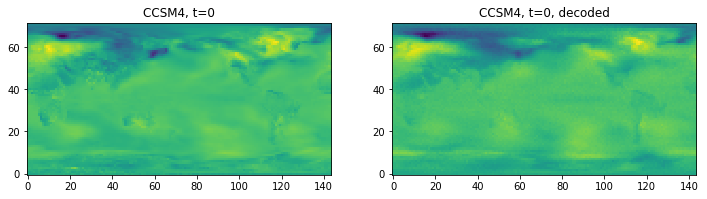

(72, 144)


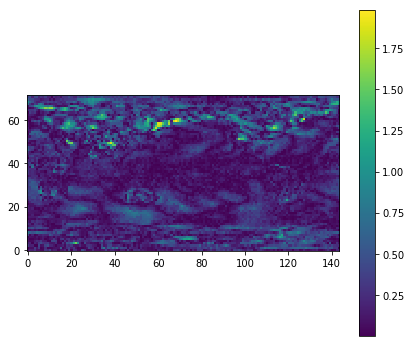

(2880, 72, 144, 1)


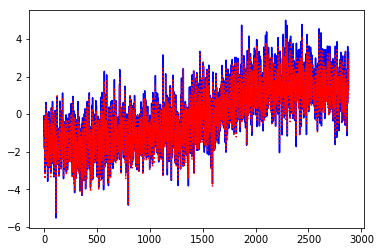

In [43]:
plot_var_spatial(X_ccsm4_arr, model, target_shape=(1, N_lat*N_lon), name="CCSM4")
plot_err_spatial(X_ccsm4_arr, model, target_shape=(1, N_lat*N_lon), name="CCSM4")
plot_var_time(X_ccsm4_arr, model, target_shape=(N_time, N_lat*N_lon))

### Convolutional model

In [27]:
N_feat_maps = 8*N_chan
latent_dims = 9*9*N_feat_maps

input_0 = Input(batch_shape=(None, N_lat, N_lon, 1))
conv_0 = Conv2D(N_feat_maps, (3,3), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(N_feat_maps, (3,3), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(conv_0))
dense_1 = Dense(latent_dims, activation='relu')(Flatten()(conv_1))
dense_2 = Dense(36*36*N_feat_maps)(dense_1)
reshaped = Reshape((36,36,N_feat_maps))(dense_2)
conv_4 = Conv2DTranspose(N_feat_maps, (3,3), strides=(2,4), activation='relu', padding='same')(reshaped)
conv_5 = Conv2D(1, (3,3), padding='same')(conv_4)
conv_model = Model(inputs=input_0, outputs=conv_5)

conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 72, 144, 1)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 72, 144, 1)        4         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 72, 144, 8)        80        
_________________________________________________________________
batch_normalization_28 (Batc (None, 72, 144, 8)        32        
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 36, 36, 8)         584       
_________________________________________________________________
flatten_14 (Flatten)         (None, 10368)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 648)               6719112   
__________

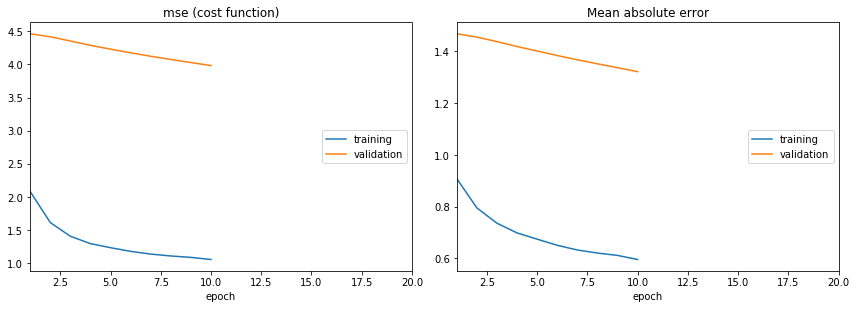

mse (cost function):
training   (min:    1.054, max:    2.079, cur:    1.054)
validation (min:    3.982, max:    4.462, cur:    3.982)

Mean absolute error:
training   (min:    0.596, max:    0.908, cur:    0.596)
validation (min:    1.321, max:    1.468, cur:    1.321)
Epoch 11/20
 7776/13824 [===============>..............] - ETA: 22s - loss: 1.0412 - mean_absolute_error: 0.5947

KeyboardInterrupt: 

In [17]:
conv_model.fit(X_all, X_all, batch_size=BATCH_SIZE, epochs=20, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])

In [21]:
plot_var_spatial(X_ccsm4_arr, conv_model)

NameError: name 'conv_model' is not defined

(2880, 72, 144, 1)


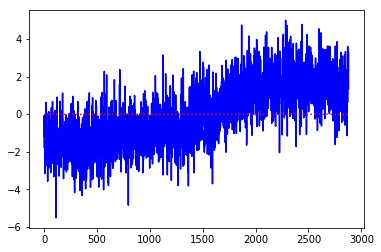

In [47]:
input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, 1))
conv_0 = Conv2D(16, (3,3), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(128, (3,3), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(128, (3,3), activation='relu', padding='same')(BatchNormalization()(conv_1))

def wta(x):
    x_max = K.max(x, axis=[0,1], keepdims=True)
    x_mask = K.cast(x >= x_max, dtype='float32')
    return x*x_mask
wta_mid = Lambda(wta)(conv_2)

conv_4 = Conv2D(128, (3,3), activation='relu', padding='same')(wta_mid)
conv_5 = Conv2D(128, (3,3), activation='relu', padding='same')(conv_4)
conv_6 = Conv2D(16, (3,3), activation='relu', padding='same')(UpSampling2D((2,4))(conv_5))
conv_7 = Conv2D(1, (3,3), padding='same')(conv_6)
conv_wta_model = Model(inputs=input_0, outputs=conv_7)

conv_wta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_wta_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (720, 72, 144, 1)         0         
_________________________________________________________________
batch_normalization_9 (Batch (720, 72, 144, 1)         4         
_________________________________________________________________
conv2d_15 (Conv2D)           (720, 36, 36, 16)         160       
_________________________________________________________________
batch_normalization_10 (Batc (720, 36, 36, 16)         64        
_________________________________________________________________
conv2d_16 (Conv2D)           (720, 36, 36, 128)        18560     
_________________________________________________________________
batch_normalization_11 (Batc (720, 36, 36, 128)        512       
_________________________________________________________________
conv2d_17 (Conv2D)           (720, 36, 36, 128)        147584    
__________

In [ ]:
conv_wta_model.fit(X_all, X_all, batch_size=BATCH_SIZE, epochs=20, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])

Train on 13824 samples, validate on 3456 samples
Epoch 1/20


### Convolutional LSTM model

In [15]:
N_time = 2880
input_0 = Input(batch_shape=(BATCH_SIZE, N_time, N_lat, N_lon, 1))
conv_0 = ConvLSTM2D(16, (3,3), strides=(2,4), return_sequences=True, activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = ConvLSTM2D(8, (3,3), strides=(2,2), return_sequences=True, activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = ConvLSTM2D(4, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))

reshape_in = Reshape((9*9*4,))
repeat = RepeatVector(N_time)(reshape_in(conv_2))
reshape_out = Reshape((N_time, 9, 9, 4))(repeat)
conv_4 = ConvLSTM2D(4, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,2)))(reshape_out))
conv_5 = ConvLSTM2D(8, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,2)))(conv_4))
conv_6 = ConvLSTM2D(16, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,4)))(conv_5))
conv_7 = ConvLSTM2D(1, (3,3), return_sequences=True, padding='same')(conv_6)
conv_model = Model(inputs=input_0, outputs=conv_7)

conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (1, 2880, 72, 144, 1)     0         
_________________________________________________________________
batch_normalization_16 (Batc (1, 2880, 72, 144, 1)     4         
_________________________________________________________________
conv_lst_m2d_21 (ConvLSTM2D) (1, 2880, 36, 36, 16)     9856      
_________________________________________________________________
batch_normalization_17 (Batc (1, 2880, 36, 36, 16)     64        
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (1, 2880, 18, 18, 8)      6944      
_________________________________________________________________
batch_normalization_18 (Batc (1, 2880, 18, 18, 8)      32        
_________________________________________________________________
conv_lst_m2d_23 (ConvLSTM2D) (1, 9, 9, 4)              1744      
__________

In [ ]:
conv_model.fit(X_all, X_all, epochs=20, callbacks=[PlotLossesCallback()])

### Dense Variational Autoencoder

In [8]:
inter_dims = int(N_lat*N_lon / 2)
latent_dims = 256
epsilon_std = 1

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, N_chan))
dense_0 = Dense(inter_dims, activation='relu')(Flatten()(input_0))
z_mean = Dense(latent_dims)(dense_0)
z_log_sigma = Dense(latent_dims)(dense_0)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(BATCH_SIZE, latent_dims), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

dense = Dense(N_lat*N_lon*N_chan, activation='relu')(z)
reshaped = Reshape((N_lat, N_lon, N_chan))(dense)
vae_model = Model(inputs=input_0, outputs=reshaped)
def vae_loss(x, x_):
    mse_loss = mse(K.flatten(x), K.flatten(x_))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae_model.compile(optimizer='adam', loss=vae_loss, metrics=['mae'])
vae_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (864, 72, 144, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (864, 10368)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (864, 5184)          53752896    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (864, 256)           1327360     dense_1[0][0]                    
_____________________________________

In [9]:
vae_model.fit(X_all, X_all, batch_size=BATCH_SIZE, epochs=20, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])

Instructions for updating:
Use tf.cast instead.
Train on 13824 samples, validate on 3456 samples
Epoch 1/20
 3456/13824 [======>.......................] - ETA: 23s - loss: nan - mean_absolute_error: nan     

KeyboardInterrupt: 

### Convolutional Variational Autoencoder

In [11]:
latent_dims = 256

input_0 = Input(batch_shape=(None, N_lat, N_lon, 1))
conv_0 = Conv2D(4, (3,3), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(4, (3,3), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(N_chan, (3,3), activation='relu', padding='same')(BatchNormalization()(conv_1))

epsilon_std = 1
z_mean = Dense(latent_dims)(Flatten()(conv_2))
z_log_sigma = Dense(latent_dims)(Flatten()(conv_2))
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(BATCH_SIZE, 18, 18, 4), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

dense = Dense(36*36*N_chan, activation='relu')(z)
conv_6 = Conv2D(4, (3,3), activation='relu', padding='same')(UpSampling2D((2,4))(Reshape((36, 36, N_chan))(dense)))
conv_7 = Conv2D(1, (3,3), padding='same')(conv_6)
vae_model = Model(inputs=input_0, outputs=conv_7)
def vae_loss(x, x_):
    mse_loss = mse(K.flatten(x), K.flatten(x_))
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae_model.compile(optimizer='adam', loss=vae_loss, metrics=['mae'])
print(vae_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (576, 72, 144, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (576, 72, 144, 1)    4           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (576, 72, 144, 4)    40          batch_normalization_14[0][0]     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (576, 72, 144, 4)    16          conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

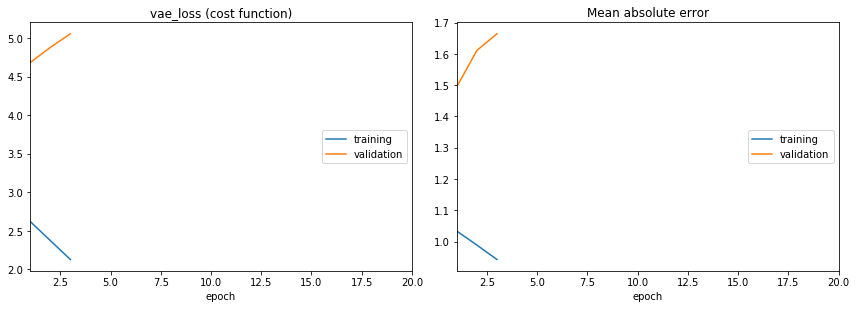

vae_loss (cost function):
training   (min:    2.129, max:    2.622, cur:    2.129)
validation (min:    4.684, max:    5.057, cur:    5.057)

Mean absolute error:
training   (min:    0.943, max:    1.034, cur:    0.943)
validation (min:    1.495, max:    1.664, cur:    1.664)
Epoch 4/20
10944/11520 [===========================>..] - ETA: 2s - loss: 1.7853 - mean_absolute_error: 0.8379

KeyboardInterrupt: 

In [12]:
vae_model.fit(X_stacked, X_stacked, batch_size=BATCH_SIZE, epochs=20, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])